In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys, os
sys.path.insert(0, '../')
from dfHelper import*

### Visual overview of data in order to choose the window size to compute amplitude

columns: Index(['InertialMeasurementUnit BACK acc_mod',
       'InertialMeasurementUnit RUA acc_mod',
       'InertialMeasurementUnit RLA acc_mod',
       'InertialMeasurementUnit LUA acc_mod',
       'InertialMeasurementUnit LLA acc_mod'],
      dtype='object')


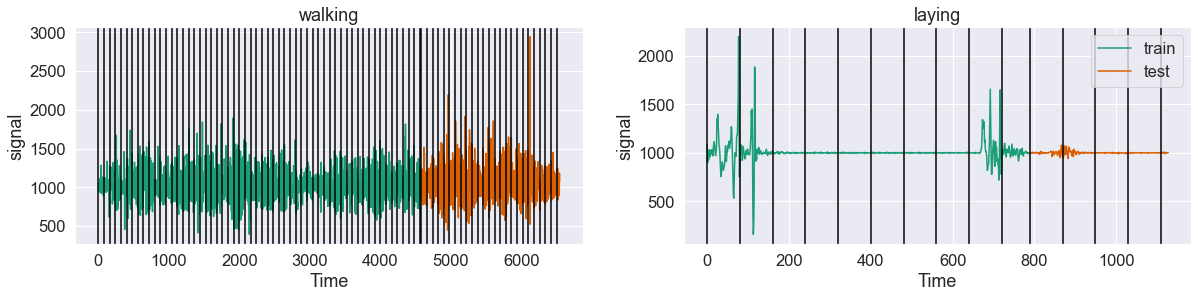

In [171]:
subject, run = 1, 1
sensors = ['IMU_acc', 'IMU_gyro','triaxial_acc']

sensor = sensors[0]
d = load_data_adl(subject, run, '../OpportunityUCIDataset')
walk, lie =  get_locomotion_data(d, [2]), get_locomotion_data(d, [5])
walk, lie = get_sensor_data(walk, sensor), get_sensor_data(lie, sensor)
walk, lie = walk[walk.columns[:-8]], lie[lie.columns[:-8]]


train_frac = 0.7
print ('columns:', walk.columns)
column = walk.columns[2]

walk_train = walk[:int(len(walk)*train_frac)]
walk_test  = walk[int(len(walk)*train_frac):]
lie_train = lie[:int(len(lie)*train_frac)]
lie_test  = lie[int(len(lie)*train_frac):]

fig, ax=plt.subplots(1,2, figsize=(20, 4))
sns.set_theme(style='darkgrid', palette='Dark2', font_scale=1.5)
walk_train[column].plot(ax=ax[0], label='train')
walk_test[column].plot(ax=ax[0], label='test')
lie_train[column].plot(ax=ax[1], label='train')
lie_test[column].plot(ax=ax[1], label='test')

ax[0].legend().remove(), ax[1].legend()
ax[0].set_xlabel('Time'), ax[1].set_xlabel('Time')
ax[0].set_ylabel('signal'), ax[1].set_ylabel('signal')


# we want to create a dataset with all the amplitudes within a window of 
# size window_size, lets visualize it to have a clear idea
window_size = 80
for i in range(len(walk_train)):
    if i % window_size == 0:
        ax[0].axvline(i, color='black')
for i in range(len(lie_train)):
    if i % window_size == 0:
        ax[1].axvline(i, color='black')
for i in range(len(walk_test)):
    if i % window_size == 0:
        ax[0].axvline(len(walk_train)+i, color='black')
for i in range(len(lie_test)):
    if i % window_size == 0:
        ax[1].axvline(len(lie_train)+i, color='black')

ax[0].set_title('walking')
ax[1].set_title('laying')
fig.savefig('figures/walking_laying_ex_window.png')

# training of the model and test on original signals

In [11]:
def prepare_dataset(split_frac, sensor, window_size=80):
    """
    create a dataset of amplitudes for walking and laying HL activity

    split_frac: fraction of data to be used for training
    sensor: sensor to be used
    window_size: size of the window to be used for the computation of the amplitude
    """
    X, y = [], []
    # for each subject, for each run
    subjects = [1,2,3]
    runs = [1,2,3, 4, 5]
    for s in subjects:
        for r in runs:
            d = load_data_adl(s, r, '../OpportunityUCIDataset')
            walk, lie =  get_locomotion_data(d, [2]), get_locomotion_data(d, [5])
            walk, lie = get_sensor_data(walk, sensor), get_sensor_data(lie, sensor)
            walk, lie = walk[walk.columns[:-8]], lie[lie.columns[:-8]]
            for c in walk.columns:
                series = walk[c]
                for i in range(len(series)):
                    if i % window_size == 0:
                        amplitude = max(series[i:i+window_size])-min(series[i:i+window_size])
                        if amplitude > 0:
                            X.append([amplitude])
                            y.append(1)
                        else: continue
            for c in lie.columns:
                series = lie[c]
                for i in range(len(series)):
                    if i % window_size == 0:
                        amplitude = max(series[i:i+window_size])-min(series[i:i+window_size])
                        if amplitude > 0:
                            X.append([amplitude])
                            y.append(0)
                        else: continue
    from sklearn.utils import shuffle
    from sklearn.model_selection import train_test_split
    X, y = shuffle(X, y)

    #split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_frac)
    return X_train, X_test, y_train, y_test

def confusion_matrix (model, X, y):
    from sklearn.metrics import confusion_matrix
    pred = model.predict(X)
    cmat = confusion_matrix(y, pred, normalize='true')
    return cmat


In [173]:
data_IMUAcc = prepare_dataset(0.2, 'IMU_acc')
data_IMUGyro = prepare_dataset(0.2, 'IMU_gyro')
data_triaxialAcc = prepare_dataset( 0.2, 'triaxial_acc')

In [12]:
from sklearn.linear_model import LogisticRegression
clf_IMUAcc = LogisticRegression(random_state=0).fit(data_IMUAcc[0], data_IMUAcc[2])
clf_IMUGyro = LogisticRegression(random_state=0).fit(data_IMUGyro[0], data_IMUGyro[2])
clf_triaxialAcc = LogisticRegression(random_state=0).fit(data_triaxialAcc[0], data_triaxialAcc[2])

NameError: name 'data_IMUAcc' is not defined

## Metrics

In [ ]:
IMUAcc_accuracy = [clf_IMUAcc.score(data_IMUAcc[1], data_IMUAcc[3]), clf_IMUAcc.score(data_IMUAcc[0], data_IMUAcc[2])]
IMUGyro_accuracy = [clf_IMUGyro.score(data_IMUGyro[1], data_IMUGyro[3]), clf_IMUGyro.score(data_IMUGyro[0], data_IMUGyro[2])]
triaxialAcc_accuracy = [clf_triaxialAcc.score(data_triaxialAcc[1], data_triaxialAcc[3]), clf_triaxialAcc.score(data_triaxialAcc[0], data_triaxialAcc[2])]

print ('IMUAcc accuracy (test/train):', IMUAcc_accuracy)
print ('IMUGyro accuracy (test/train):', IMUGyro_accuracy)
print ('triaxialAcc accuracy (test/train):', triaxialAcc_accuracy)

IMUAcc_cmat = confusion_matrix(clf_IMUAcc, data_IMUAcc[1],  data_IMUAcc[3])
IMUGyro_cmat = confusion_matrix(clf_IMUGyro, data_IMUGyro[1],  data_IMUGyro[3])
triaxialAcc_cmat = confusion_matrix(clf_triaxialAcc, data_triaxialAcc[1],  data_triaxialAcc[3])

print ('\nIMUAcc confusion matrix (test)\n', IMUAcc_cmat)
print ('\nIMUGyro confusion matrix (test)\n', IMUGyro_cmat)
print ('\ntriaxialAcc confusion matrix (test)\n', triaxialAcc_cmat)

IMUAcc accuracy (test/train): [0.964095744680851, 0.9621010638297872]
IMUGyro accuracy (test/train): [0.9607712765957447, 0.9534574468085106]
triaxialAcc accuracy (test/train): [0.9356963613550816, 0.9291035997176692]

IMUAcc confusion matrix (test)
 [[0.81276596 0.18723404]
 [0.00788022 0.99211978]]

IMUGyro confusion matrix (test)
 [[0.81180812 0.18819188]
 [0.00648824 0.99351176]]

triaxialAcc confusion matrix (test)
 [[0.72745491 0.27254509]
 [0.0256601  0.9743399 ]]


# Test on the amplitude of the centers

In [ ]:
# load the clustered signals 
def centers_amplitude(sensor, nclusters, window_size=80, metric='euclidean'):       
    """
    create a dataset of amplitudes for walking and laying HL activity working on the signal centers

    sensor: sensor to be used
    nclusters: number of clusters to be used
    window_size: size of the window to be used for the computation of the amplitude
    metric: metric to be used for the clustering
    """
      
    subjects = [1,2,3]
    runs = [1,2,3, 4]
    X, y = [], []

    for s in subjects:
        for r in runs:
            data_laying = pd.read_csv('../clustering/clustering_results_{}/subject_{}/run_{}/laying/sensor_type_{}/{}_clusters.csv'.format(metric, s, r, sensor, nclusters))
            data_walking = pd.read_csv('../clustering/clustering_results_{}/subject_{}/run_{}/walking/sensor_type_{}/{}_clusters.csv'.format(metric, s, r, sensor, nclusters))

            for c in range(nclusters):
                lie = data_laying['center {}'.format(c)]
                walk = data_walking['centers {}'.format(c)]
                for i in range(len(lie)):
                    if i % window_size == 0:
                        amplitude = max(lie[i:i+window_size])-min(lie[i:i+window_size])
                        if amplitude > 0:
                            X.append([amplitude])
                            y.append(0)
                        else: continue
                for i in range(len(walk)):
                    if i % window_size == 0:
                        amplitude = max(walk[i:i+window_size])-min(walk[i:i+window_size])
                        if amplitude > 0:
                            X.append([amplitude])
                            y.append(1)
                        else: continue
    from sklearn.utils import shuffle
    X, y = shuffle(X, y)
    return X, y            

In [ ]:
results = pd.DataFrame()
for c in range(1,5):

    print ('\n{} CENTERS'.format(c))
    data_centers_IMUAcc = centers_amplitude('IMU_acc', c)
    data_centers_IMUGyro = centers_amplitude('IMU_gyro', c)
    data_centers_triaxialAcc = centers_amplitude('triaxial_acc', c)

    IMUAcc_accuracy = clf_IMUAcc.score(data_centers_IMUAcc[0], data_centers_IMUAcc[1])
    IMUGyro_accuracy = clf_IMUGyro.score(data_centers_IMUGyro[0], data_centers_IMUGyro[1])
    triaxialAcc_accuracy = clf_triaxialAcc.score(data_centers_triaxialAcc[0], data_centers_triaxialAcc[1])

    IMUAcc_cmat = confusion_matrix(clf_IMUAcc, data_centers_IMUAcc[0], data_centers_IMUAcc[1])
    IMUGyro_cmat = confusion_matrix(clf_IMUGyro,data_centers_IMUGyro[0], data_centers_IMUGyro[1])
    triaxialAcc_cmat = confusion_matrix(clf_triaxialAcc, data_centers_triaxialAcc[0], data_centers_triaxialAcc[1])

    print ('\nIMUAcc confusion matrix (test)\n', IMUAcc_cmat)
    print ('\nIMUGyro confusion matrix (test)\n', IMUAcc_cmat)
    print ('\ntriaxialAcc confusion matrix (test)\n', IMUAcc_cmat)


    results = results.append({'clusters': c, 'IMUAcc': IMUAcc_accuracy, 'IMUGyro': IMUGyro_accuracy, 'triaxialAcc': triaxialAcc_accuracy}, ignore_index=True)
    print ('\nclusters:', c, 'IMUAcc accuracy:', IMUAcc_accuracy, 'IMUGyro accuracy:', IMUGyro_accuracy, 'triaxialAcc accuracy:', triaxialAcc_accuracy)
results.set_index('clusters', inplace=True)


1 CENTERS

IMUAcc confusion matrix (test)
 [[0.90686275 0.09313725]
 [0.02001907 0.97998093]]

IMUGyro confusion matrix (test)
 [[0.90686275 0.09313725]
 [0.02001907 0.97998093]]

triaxialAcc confusion matrix (test)
 [[0.90686275 0.09313725]
 [0.02001907 0.97998093]]

clusters: 1 IMUAcc accuracy: 0.9680766161213089 IMUGyro accuracy: 0.9505187549880287 triaxialAcc accuracy: 0.8633257403189066

2 CENTERS

IMUAcc confusion matrix (test)
 [[0.71813725 0.28186275]
 [0.00619638 0.99380362]]

IMUGyro confusion matrix (test)
 [[0.71813725 0.28186275]
 [0.00619638 0.99380362]]

triaxialAcc confusion matrix (test)
 [[0.71813725 0.28186275]
 [0.00619638 0.99380362]]

clusters: 2 IMUAcc accuracy: 0.9489225857940942 IMUGyro accuracy: 0.9449321628092577 triaxialAcc accuracy: 0.9242596810933941

3 CENTERS

IMUAcc confusion matrix (test)
 [[0.74019608 0.25980392]
 [0.00540197 0.99459803]]

IMUGyro confusion matrix (test)
 [[0.74019608 0.25980392]
 [0.00540197 0.99459803]]

triaxialAcc confusion matri

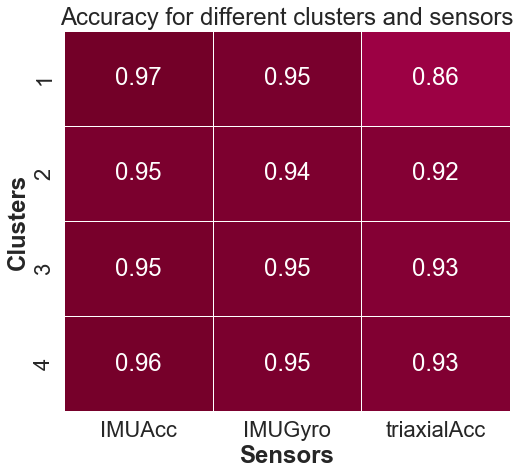

In [ ]:
sns.set_theme(style='whitegrid', palette='mako', font_scale = 2)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(results, annot=True,  linewidths=0.5, linecolor='white', cmap='PuRd', vmin = 0, vmax = 1, cbar=False, ax=ax)
ax.set_yticklabels([1,2,3,4])
ax.set_ylabel('Clusters',fontweight='bold')
ax.set_title('Accuracy for different clusters and sensors')
ax.set_xlabel('Sensors',fontweight='bold')
fig.savefig('../clustering/clustering_results_euclidean/accuracy_clusters.pdf')

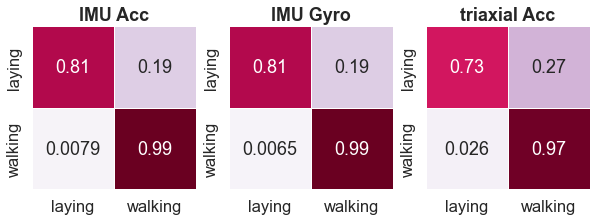

In [ ]:
# IMUAcc confusion matrix (test)
imuacc = [[0.81276596, 0.18723404], [0.00788022, 0.99214454]]
IMUGyro=[[0.81180812, 0.18819188],[0.00648824, 0.99214454]]
triaxialAcc=[[0.72745491, 0.27254509],[0.0256601, 0.9743399]]

sns.set_theme(style='whitegrid', palette='mako', font_scale = 1.5)
fig, ax = plt.subplots(1,3, figsize=(10,3))
sns.heatmap(imuacc, annot=True,  linewidths=0.5, linecolor='white', cmap='PuRd', vmin = 0, vmax = 1, cbar=False, ax=ax[0])
sns.heatmap(IMUGyro, annot=True,  linewidths=0.5, linecolor='white', cmap='PuRd', vmin = 0, vmax = 1, cbar=False, ax=ax[1])
sns.heatmap(triaxialAcc, annot=True,  linewidths=0.5, linecolor='white', cmap='PuRd', vmin = 0, vmax = 1, cbar=False, ax=ax[2])
ax[0].set_yticklabels(['laying', 'walking'])
ax[1].set_yticklabels(['laying', 'walking'])
ax[2].set_yticklabels(['laying', 'walking'])
ax[0].set_xticklabels(['laying', 'walking'])
ax[1].set_xticklabels(['laying', 'walking'])
ax[2].set_xticklabels(['laying', 'walking'])
ax[0].set_title('IMU Acc', fontweight='bold')
ax[1].set_title('IMU Gyro', fontweight='bold')
ax[2].set_title('triaxial Acc', fontweight='bold')
fig.savefig('../clustering/clustering_results_euclidean/confusion_matrix_test.pdf')


# Heterogeneous sensors

In [47]:
def prepare_dataset_het(split_frac, window_size=30):
    """
    create a dataset of amplitudes for walking and laying HL activity

    split_frac: fraction of data to be used for training
    sensor: sensor to be used
    window_size: size of the window to be used for the computation of the amplitude
    """
    from sklearn.preprocessing import StandardScaler, Normalizer
    X, y = [], []
    # for each subject, for each run
    subjects = [1,2,3]
    runs = [1,2,3, 4, 5]
    for s in subjects:
        for r in runs:
            # IMU RUA, RLA, BACK
            # triaxial: hip, back, RUA^, RUA_, RWR, RKN_
            d = load_data_adl(s, r, '../OpportunityUCIDataset')
            walk, lie =  get_locomotion_data(d, [2]), get_locomotion_data(d, [5])

            imu_acc_walk, imu_acc_lie  = get_sensor_data(walk, 'IMU_acc').dropna(), get_sensor_data(lie, 'IMU_acc').dropna()
            imu_gyro_walk, imu_gyro_lie = get_sensor_data(walk, 'IMU_gyro').dropna(), get_sensor_data(lie, 'IMU_gyro').dropna()
            triaxial_acc_walk, triaxial_acc_lie = get_sensor_data(walk, 'triaxial_acc').dropna(), get_sensor_data(lie, 'triaxial_acc').dropna()
        
            lie = imu_acc_lie[imu_acc_lie.columns[:-8]]
            lie = lie.join(imu_gyro_lie[imu_gyro_lie.columns[:-8]])
            lie = lie.join(triaxial_acc_lie[triaxial_acc_lie.columns[:-8]])

            # scaler = StandardScaler()
            # lie = scaler.fit_transform(lie)
            # lie = pd.DataFrame(lie)

            walk = imu_acc_walk[imu_acc_walk.columns[:-8]]
            walk = walk.join(imu_gyro_walk[imu_gyro_walk.columns[:-8]])
            walk = walk.join(triaxial_acc_walk[triaxial_acc_walk.columns[:-8]])

            # walk = scaler.fit_transform(walk)
            # walk = pd.DataFrame(walk)

            nlie_data = 0
            for c in lie.columns:
                series = lie[c]
                for i in range(len(series)):
                    if i % window_size == 0:
                        amplitude = max(series[i:i+window_size])-min(series[i:i+window_size])
                        if amplitude > 0:
                            nlie_data += 1
                            X.append([amplitude])
                            y.append(0)
                        else: continue

            nwalk_data = 0
            for c in walk.columns:
                series = walk[c]
                for i in range(len(series)):
                    if i % window_size == 0:
                        if nwalk_data > nlie_data: break
                        amplitude = max(series[i:i+window_size])-min(series[i:i+window_size])
                        if amplitude > 0:
                            nwalk_data += 1
                            X.append([amplitude])
                            y.append(1)
                        else: continue

    X = np.array(X)
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X).tolist()
    
    print ('nlie_data: ', nlie_data)
    print ('nwalk_data: ', nwalk_data)
    
    from sklearn.utils import shuffle
    from sklearn.model_selection import train_test_split
    X, y = shuffle(X, y)

    #split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_frac)
    return X_train, X_test, y_train, y_test
    
data_het = prepare_dataset_het(0.2)

nlie_data:  643
nwalk_data:  644


In [48]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(data_het[0], data_het[2])

het_accuracy = [clf.score(data_het[1], data_het[3]), clf.score(data_het[0], data_het[2])]
print ('Accuracy (test/train):', het_accuracy)

het_cmat = confusion_matrix(clf, data_het[1],  data_het[3])
print ('\n confusion matrix (test)\n', het_cmat)

Accuracy (test/train): [0.8252032520325203, 0.8230405930531476]

 confusion matrix (test)
 [[0.85707457 0.14292543]
 [0.20669856 0.79330144]]


In [50]:
# load the clustered signals 
def centers_amplitude_het(nclusters, window_size=50, metric='euclidean'):       
    """
    create a dataset of amplitudes for walking and laying HL activity working on the signal centers

    sensor: sensor to be used
    nclusters: number of clusters to be used
    window_size: size of the window to be used for the computation of the amplitude
    metric: metric to be used for the clustering
    """

    subjects = [1,2,3]
    runs = [1,2,3,4]
    X, y = [], []
    from sklearn.preprocessing import StandardScaler
    for s in subjects:
        for r in runs:
            data_laying = pd.read_csv('../clustering/clustering_results_{}/subject_{}/run_{}/laying/sensor_type_{}/{}_clusters.csv'.format(metric, s, r, 'all', nclusters))
            data_walking = pd.read_csv('../clustering/clustering_results_{}/subject_{}/run_{}/walking/sensor_type_{}/{}_clusters.csv'.format(metric, s, r, 'all', nclusters))
            
            data_laying = data_laying[data_laying.columns[:nclusters]]
            data_walking = data_walking[data_walking.columns[:nclusters]]

            if data_laying.empty or data_walking.empty: continue

            for c in range(nclusters):
                lie = data_laying[data_laying.columns[c]]
                walk = data_walking[data_walking.columns[c]]

                ndata_lie = 0
                for i in range(len(lie)):
                    if i % window_size == 0:
                        amplitude = max(lie[i:i+window_size])-min(lie[i:i+window_size])
                        if amplitude > 0:
                            ndata_lie += 1
                            X.append([amplitude])
                            y.append(0)
                        else: continue
                ndata_walk = 0
                for i in range(len(walk)):
                    if i % window_size == 0:
                        amplitude = max(walk[i:i+window_size])-min(walk[i:i+window_size])
                        if ndata_walk > ndata_lie: break
                        if amplitude > 0:
                            ndata_walk += 1
                            X.append([amplitude])
                            y.append(1)
                        else: continue

    X = np.array(X)
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X).tolist()
    from sklearn.utils import shuffle
    X, y = shuffle(X, y)
    return X, y          

In [75]:
results = pd.DataFrame()
for c in range(2,10):

    print ('\n{} CENTERS'.format(c))
    data_centers = centers_amplitude_het(c)

    accuracy = clf.score(data_centers[0], data_centers[1])
    cmat = confusion_matrix(clf, data_centers[0], data_centers[1])
    print ('\nIMUAcc confusion matrix (test)\n', cmat)

    results = results.append({'clusters': c, 'acc': accuracy}, ignore_index=True)
    print ('\nclusters:', c, 'accuracy:', accuracy)
results.set_index('clusters', inplace=True)


2 CENTERS

IMUAcc confusion matrix (test)
 [[0.76519337 0.23480663]
 [0.22774869 0.77225131]]

clusters: 2 accuracy: 0.7688172043010753

3 CENTERS

IMUAcc confusion matrix (test)
 [[0.78821363 0.21178637]
 [0.17801047 0.82198953]]

clusters: 3 accuracy: 0.8055555555555556

4 CENTERS

IMUAcc confusion matrix (test)
 [[0.80248619 0.19751381]
 [0.14136126 0.85863874]]

clusters: 4 accuracy: 0.8313172043010753

5 CENTERS

IMUAcc confusion matrix (test)
 [[0.79668508 0.20331492]
 [0.14659686 0.85340314]]

clusters: 5 accuracy: 0.8258064516129032

6 CENTERS

IMUAcc confusion matrix (test)
 [[0.80847145 0.19152855]
 [0.14397906 0.85602094]]

clusters: 6 accuracy: 0.8328853046594982

7 CENTERS

IMUAcc confusion matrix (test)
 [[0.81294396 0.18705604]
 [0.12789828 0.87210172]]

clusters: 7 accuracy: 0.8433179723502304

8 CENTERS

IMUAcc confusion matrix (test)
 [[0.82803867 0.17196133]
 [0.1315445  0.8684555 ]]

clusters: 8 accuracy: 0.8487903225806451

9 CENTERS

IMUAcc confusion matrix (test

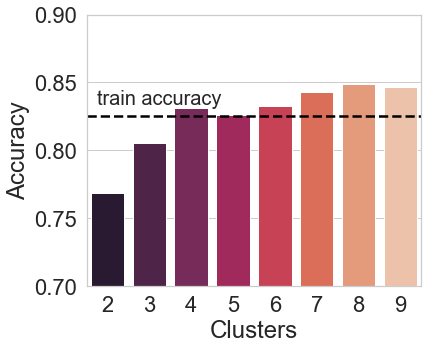

In [76]:
sns.set_theme(style='whitegrid', palette='rocket', font_scale = 2)
fig, ax = plt.subplots(figsize=(6,5))
sns.barplot(x=results.index, y=results['acc'], ax=ax, palette='rocket')

ax.axhline(y=het_accuracy[0], color='black', linestyle='--', label='train accuracy', lw=2.5)
fig.text (y=0.63, x=0.15, s='train accuracy',  fontsize=20)
ax.set_ylabel('Accuracy')
ax.set_ylim(0.7,.9)
ax.set_xticklabels([2,3,4, 5, 6, 7, 8, 9])
ax.set_xlabel('Clusters')
fig.savefig('../clustering/clustering_results_euclidean/heterogeneous_accuracy_amplitude_clusters.pdf', bbox_inches='tight')